# ECEN 4322-5322 Data and Network Science

## Title- Fare prediction for flights


#### Group Members - Chirag Chandrashekar, Chris Alexander, Viveka Salinamakki

## Introduction 

The dataset chosen for analysis is the itineraries of flights in the USA over **6 months**. For exploratory data analysis, we aim to find the airport with the highest traffic or the best-connected airports, the price of flights during the different hours of the day, the average/minimum travel distance for which people prefer flight, whether an average flight is fully booked/percentage of flights booked, and popular airlines. The end goal here is to predict the fare of a flight. Due to the large number of rows and features, the prediction can provide a good estimation of the fare. Techniques such as data grouping and manipulation, visualization, regular expressions, data modeling, feature engineering, model validation, and prediction will help achieve our goal. 


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Importing the Data

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ecen5322_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

### Sampling the Dataset

The original file is sampled due to its size of **30gb(83 million entries)** not able to be read on to the ram. Hence, this is solved by reading the file into the chunks of 1 million entries and sampling all the chunks to get a final dataset of **500 thousand entries**. The below commented code was used to sample the data and made a new csv file with the sample data which is being directly imported.

In [2]:
"""
dfs=[]
with pd.read_csv("car_price_prediction.csv", chunksize=1000000) as reader: #read as chunks due to low system resorces to read 30gb file
    reader
    for chunk in reader:
        #print(type(chunk))
        data_index=chunk.index
        shuffled_indices = np.random.permutation(data_index)  #shuffling and sampling data to reduce the data to 500000 entries
        #print(chunk.loc[shuffled_indices])
        #print(type(chunk))
        chunk,leftover= np.split(chunk.loc[shuffled_indices],[12000]) #selects first N rows from each chunk
        #print(type(chunk))
        #print(chunk)
        #chunks=chunk.to_frame
        #print(chunks)
        dfs.append(chunk) #makes a list of dataframe chunks
        #joined_chunk=pd.concat(chunk)
        #print(joined_chunk)
final_df=pd.concat(dfs) #concats all the chunks in the list of dataframe
print("final dataframe")
final_df
"""

'\ndfs=[]\nwith pd.read_csv("car_price_prediction.csv", chunksize=1000000) as reader: #read as chunks due to low system resorces to read 30gb file\n    reader\n    for chunk in reader:\n        #print(type(chunk))\n        data_index=chunk.index\n        shuffled_indices = np.random.permutation(data_index)  #shuffling and sampling data to reduce the data to 500000 entries\n        #print(chunk.loc[shuffled_indices])\n        #print(type(chunk))\n        chunk,leftover= np.split(chunk.loc[shuffled_indices],[12000]) #selects first N rows from each chunk\n        #print(type(chunk))\n        #print(chunk)\n        #chunks=chunk.to_frame\n        #print(chunks)\n        dfs.append(chunk) #makes a list of dataframe chunks\n        #joined_chunk=pd.concat(chunk)\n        #print(joined_chunk)\nfinal_df=pd.concat(dfs) #concats all the chunks in the list of dataframe\nprint("final dataframe")\nfinal_df\n'

In [3]:
#Load data to new csv file
#final_df
'''
data_index2=final_df.index
shuffled_indices2 = np.random.permutation(data_index2)
final_df2,leftover2=np.split(final_df.loc[shuffled_indices2],[500000])
final_df2
'''

'\ndata_index2=final_df.index\nshuffled_indices2 = np.random.permutation(data_index2)\nfinal_df2,leftover2=np.split(final_df.loc[shuffled_indices2],[500000])\nfinal_df2\n'

Importing the sampled csv data file

In [4]:
#New read_csv function to read empty values as -1 and remove unamed column
data=pd.read_csv("sampled_file.csv"
                 #, dtype=str
                 , keep_default_na=True
                 , na_values=-1
                 , na_filter=True).drop(columns=['Unnamed: 0'])
data

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,e95cef0009893d65558d17324e468aea,2022-06-01,2022-06-15,PHL,JFK,SUAJZNB3,PT5H17M,0,True,False,...,1655309340||1655323200,2022-06-15T12:09:00.000-04:00||2022-06-15T16:0...,BOS||JFK,PHL||BOS,American Airlines||American Airlines,AA||AA,Airbus A321||AIRBUS INDUSTRIE A321 SHARKLETS,5160||4920,280||185,coach||coach
1,778d47d0785023302cd075d735d27db8,2022-08-11,2022-08-20,CLT,ATL,TA7NA0MC,PT14H,1,False,False,...,1661037300||1661050560||1661081220,2022-08-20T19:15:00.000-04:00||2022-08-20T22:5...,DTW||IND||ATL,CLT||DTW||IND,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Boeing 737-900,6480||4020||5220,505||241||434,coach||coach||coach
2,55ca7cc1d822f310963a25d84656bb47,2022-06-26,2022-07-01,OAK,JFK,HA0NA0MC,PT8H13M,0,False,False,...,1656706200||1656730740,2022-07-01T13:10:00.000-07:00||2022-07-01T22:5...,LAX||JFK,OAK||LAX,Delta||Delta,DL||DL,Embraer 175 (Enhanced Winglets)||,5040||20040,338||2458,coach||coach
3,598db4391eb0bc5752b09c871111a5ce,2022-05-14,2022-05-23,BOS,EWR,QAA3OFEN,PT1H41M,0,False,False,...,1653347940,2022-05-23T19:19:00.000-04:00,EWR,BOS,United,UA,Airbus A319,6060,185,coach
4,e09441b23c76e8a35be3acb61d8e3e95,2022-09-25,2022-10-13,ATL,BOS,TAUNX0BC,PT10H32M,0,True,False,...,1665667500||1665697620,2022-10-13T09:25:00.000-04:00||2022-10-13T17:4...,JFK||BOS,ATL||JFK,Delta||Delta,DL||DL,Boeing 737-900||Airbus A220-100,7800||5220,762||185,coach||coach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,cfd0ca3c7574a87f1ce1dfa83d1a053b,2022-07-02,2022-07-15,LAX,CLT,HA7OA0MQ,PT9H10M,1,False,False,...,1657969320||1657986300,2022-07-16T07:02:00.000-04:00||2022-07-16T11:4...,DTW||CLT,LAX||DTW,Delta||Delta,DL||DL,Airbus A321||Boeing 717,16020||6300,1985||505,coach||coach
499996,3c671c288391b26e5888c84ef143424d,2022-05-04,2022-06-23,CLT,LAX,UAVNA0MC,PT14H11M,0,False,False,...,1655982720||1655995500||1656029760,2022-06-23T07:12:00.000-04:00||2022-06-23T09:4...,ATL||DFW||LAX,CLT||ATL||DFW,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Airbus A320,4020||8100||11760,228||725||1238,coach||coach||coach
499997,2313cf9772214eaddf14651c8847eaeb,2022-08-14,2022-08-26,BOS,OAK,QAA0OHEN,PT11H11M,0,False,False,...,1661558040||1661573100||1661583120,2022-08-26T18:54:00.000-05:00||2022-08-26T22:0...,IAH||SLC||OAK,BOS||IAH||SLC,United||Delta||Delta,UA||DL||DL,Airbus A320||Airbus A319||Airbus A220-100,15180||11460||6780,1602||1204||588,coach||coach||coach
499998,9141b51058bfbdf9adc91abb2be9078c,2022-08-09,2022-09-06,EWR,SFO,L7AHZNN1,PT8H13M,0,False,False,...,1662485760||1662506040,2022-09-06T12:36:00.000-05:00||2022-09-06T16:1...,ORD||SFO,EWR||ORD,American Airlines||American Airlines,AA||AA,Boeing 737-800||Boeing 737-800,9300||16740,720||1847,coach||coach


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Cleaning the dataset

### Drop rows with values 'NaN'

The rows with the values **'NaN'** will be dropped except for the description.

In [5]:
data = data.dropna(subset=['totalTravelDistance'])
print(data.iloc[:,0:28].isna().sum())

legId                                   0
searchDate                              0
flightDate                              0
startingAirport                         0
destinationAirport                      0
fareBasisCode                           0
travelDuration                          0
elapsedDays                             0
isBasicEconomy                          0
isRefundable                            0
isNonStop                               0
baseFare                                0
totalFare                               0
seatsRemaining                          0
totalTravelDistance                     0
segmentsDepartureTimeEpochSeconds       0
segmentsDepartureTimeRaw                0
segmentsArrivalTimeEpochSeconds         0
segmentsArrivalTimeRaw                  0
segmentsArrivalAirportCode              0
segmentsDepartureAirportCode            0
segmentsAirlineName                     0
segmentsAirlineCode                     0
segmentsEquipmentDescription      

### Function to change True and False to 1 and 0

The columns with values True and False will be changed to 1 and 0 which will be better to train a model.

In [6]:
def map_true_false(df, columnName):
    """
        Inputs:
            df [Dataframe]: Dataframe on which the operation is performed
            columnName [String]: The column which is being modified
        
        Output:
            New Dataframe with the modified
    """
    df[columnName]=df[columnName].map(dict({True: 1, False: 0}))
    return df

data=map_true_false(data,'isBasicEconomy')
data=map_true_false(data,'isRefundable')
data=map_true_false(data,'isNonStop')
data

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,e95cef0009893d65558d17324e468aea,2022-06-01,2022-06-15,PHL,JFK,SUAJZNB3,PT5H17M,0,1,0,...,1655309340||1655323200,2022-06-15T12:09:00.000-04:00||2022-06-15T16:0...,BOS||JFK,PHL||BOS,American Airlines||American Airlines,AA||AA,Airbus A321||AIRBUS INDUSTRIE A321 SHARKLETS,5160||4920,280||185,coach||coach
1,778d47d0785023302cd075d735d27db8,2022-08-11,2022-08-20,CLT,ATL,TA7NA0MC,PT14H,1,0,0,...,1661037300||1661050560||1661081220,2022-08-20T19:15:00.000-04:00||2022-08-20T22:5...,DTW||IND||ATL,CLT||DTW||IND,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Boeing 737-900,6480||4020||5220,505||241||434,coach||coach||coach
2,55ca7cc1d822f310963a25d84656bb47,2022-06-26,2022-07-01,OAK,JFK,HA0NA0MC,PT8H13M,0,0,0,...,1656706200||1656730740,2022-07-01T13:10:00.000-07:00||2022-07-01T22:5...,LAX||JFK,OAK||LAX,Delta||Delta,DL||DL,Embraer 175 (Enhanced Winglets)||,5040||20040,338||2458,coach||coach
3,598db4391eb0bc5752b09c871111a5ce,2022-05-14,2022-05-23,BOS,EWR,QAA3OFEN,PT1H41M,0,0,0,...,1653347940,2022-05-23T19:19:00.000-04:00,EWR,BOS,United,UA,Airbus A319,6060,185,coach
4,e09441b23c76e8a35be3acb61d8e3e95,2022-09-25,2022-10-13,ATL,BOS,TAUNX0BC,PT10H32M,0,1,0,...,1665667500||1665697620,2022-10-13T09:25:00.000-04:00||2022-10-13T17:4...,JFK||BOS,ATL||JFK,Delta||Delta,DL||DL,Boeing 737-900||Airbus A220-100,7800||5220,762||185,coach||coach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,cfd0ca3c7574a87f1ce1dfa83d1a053b,2022-07-02,2022-07-15,LAX,CLT,HA7OA0MQ,PT9H10M,1,0,0,...,1657969320||1657986300,2022-07-16T07:02:00.000-04:00||2022-07-16T11:4...,DTW||CLT,LAX||DTW,Delta||Delta,DL||DL,Airbus A321||Boeing 717,16020||6300,1985||505,coach||coach
499996,3c671c288391b26e5888c84ef143424d,2022-05-04,2022-06-23,CLT,LAX,UAVNA0MC,PT14H11M,0,0,0,...,1655982720||1655995500||1656029760,2022-06-23T07:12:00.000-04:00||2022-06-23T09:4...,ATL||DFW||LAX,CLT||ATL||DFW,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Airbus A320,4020||8100||11760,228||725||1238,coach||coach||coach
499997,2313cf9772214eaddf14651c8847eaeb,2022-08-14,2022-08-26,BOS,OAK,QAA0OHEN,PT11H11M,0,0,0,...,1661558040||1661573100||1661583120,2022-08-26T18:54:00.000-05:00||2022-08-26T22:0...,IAH||SLC||OAK,BOS||IAH||SLC,United||Delta||Delta,UA||DL||DL,Airbus A320||Airbus A319||Airbus A220-100,15180||11460||6780,1602||1204||588,coach||coach||coach
499998,9141b51058bfbdf9adc91abb2be9078c,2022-08-09,2022-09-06,EWR,SFO,L7AHZNN1,PT8H13M,0,0,0,...,1662485760||1662506040,2022-09-06T12:36:00.000-05:00||2022-09-06T16:1...,ORD||SFO,EWR||ORD,American Airlines||American Airlines,AA||AA,Boeing 737-800||Boeing 737-800,9300||16740,720||1847,coach||coach


### Function to remove outliers

`remove_outliers` function removes the outliers depending on the given condition.

In [7]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
  
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    data_2=data[data[variable]<= upper]
    data_3=data_2[data_2[variable]>= lower]
    return data_3

In [8]:
data = remove_outliers(data, 'baseFare', lower = 60)
data.loc[:,'baseFare'].sort_values()

252841      60.47
423629      60.47
282635      60.47
218454      60.47
357654      60.47
           ...   
373476    3674.42
270007    4407.44
423259    4407.44
210383    4407.44
403847    4557.21
Name: baseFare, Length: 455587, dtype: float64

### Convert date time column to date time format

The dates are converted to datetime format using `convertToDateTimeFormat` so that the year, month and day will be easily accessible.

In [9]:
def convertToDateTimeFormat(df, columnName):
    """
    Inputs:
        df [Dataframe]: Dataframe on which the operation is performed
        columnName [String]: The column which has dates to be converted into datetime format
                        Acceptable names are 'searchDate' and 'flightDate'
        
    Output:
        New Dataframe with dates converted into datetime format
    """
    df[columnName]=pd.to_datetime(df[columnName], format="%Y-%m-%d")
    return df

In [10]:
data=convertToDateTimeFormat(data, 'searchDate')
data=convertToDateTimeFormat(data, 'flightDate')

In [11]:
data['searchDate']

0        2022-06-01
1        2022-08-11
2        2022-06-26
3        2022-05-14
4        2022-09-25
            ...    
499995   2022-07-02
499996   2022-05-04
499997   2022-08-14
499998   2022-08-09
499999   2022-09-01
Name: searchDate, Length: 455587, dtype: datetime64[ns]

### Create columns for month and day for the date columns

The month and year are extracted from the date columns using `createMonthDay` so that they more usable.

In [12]:
def createMonthDay(df, columnName):
    """
    Inputs:
        df [Dataframe]: Dataframe on which the operation is performed
        columnName [String]: The column which has dates from which month and year are extracted
                        Acceptable names are 'searchDate' and 'flightDate'
        
    Output:
        New Dataframe with with the columns for month and year added from the the column columnName
    """
    df[columnName+'_month']=df[columnName].dt.month
    df[columnName+'_day']=df[columnName].dt.day
    return df

In [13]:
data=createMonthDay(data, 'searchDate')
data=createMonthDay(data, 'flightDate')

In [14]:
data

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,searchDate_month,searchDate_day,flightDate_month,flightDate_day
0,e95cef0009893d65558d17324e468aea,2022-06-01,2022-06-15,PHL,JFK,SUAJZNB3,PT5H17M,0,1,0,...,American Airlines||American Airlines,AA||AA,Airbus A321||AIRBUS INDUSTRIE A321 SHARKLETS,5160||4920,280||185,coach||coach,6,1,6,15
1,778d47d0785023302cd075d735d27db8,2022-08-11,2022-08-20,CLT,ATL,TA7NA0MC,PT14H,1,0,0,...,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Boeing 737-900,6480||4020||5220,505||241||434,coach||coach||coach,8,11,8,20
2,55ca7cc1d822f310963a25d84656bb47,2022-06-26,2022-07-01,OAK,JFK,HA0NA0MC,PT8H13M,0,0,0,...,Delta||Delta,DL||DL,Embraer 175 (Enhanced Winglets)||,5040||20040,338||2458,coach||coach,6,26,7,1
3,598db4391eb0bc5752b09c871111a5ce,2022-05-14,2022-05-23,BOS,EWR,QAA3OFEN,PT1H41M,0,0,0,...,United,UA,Airbus A319,6060,185,coach,5,14,5,23
4,e09441b23c76e8a35be3acb61d8e3e95,2022-09-25,2022-10-13,ATL,BOS,TAUNX0BC,PT10H32M,0,1,0,...,Delta||Delta,DL||DL,Boeing 737-900||Airbus A220-100,7800||5220,762||185,coach||coach,9,25,10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,cfd0ca3c7574a87f1ce1dfa83d1a053b,2022-07-02,2022-07-15,LAX,CLT,HA7OA0MQ,PT9H10M,1,0,0,...,Delta||Delta,DL||DL,Airbus A321||Boeing 717,16020||6300,1985||505,coach||coach,7,2,7,15
499996,3c671c288391b26e5888c84ef143424d,2022-05-04,2022-06-23,CLT,LAX,UAVNA0MC,PT14H11M,0,0,0,...,Delta||Delta||Delta,DL||DL||DL,Boeing 717||Airbus A321||Airbus A320,4020||8100||11760,228||725||1238,coach||coach||coach,5,4,6,23
499997,2313cf9772214eaddf14651c8847eaeb,2022-08-14,2022-08-26,BOS,OAK,QAA0OHEN,PT11H11M,0,0,0,...,United||Delta||Delta,UA||DL||DL,Airbus A320||Airbus A319||Airbus A220-100,15180||11460||6780,1602||1204||588,coach||coach||coach,8,14,8,26
499998,9141b51058bfbdf9adc91abb2be9078c,2022-08-09,2022-09-06,EWR,SFO,L7AHZNN1,PT8H13M,0,0,0,...,American Airlines||American Airlines,AA||AA,Boeing 737-800||Boeing 737-800,9300||16740,720||1847,coach||coach,8,9,9,6


### Extracting duration of the flight in hours

Current format of the time is in as string form with other character, Eg: `PT5H17M` which is 5 hours and 17 mins. the time is extracted using regex and saved into a new `Flight_duration` column in hours.

In [15]:
def extract_travel_duration(dataFrame, columnName):
    """
    Inputs:
        df [Dataframe]: Dataframe on which the operation is performed
        columnName [String]: The column which is being modified
        
    Output:
        New Dataframe with the modified
    """
    time_columns = pd.DataFrame()
    hour_segment=r"(\d+)H"
    min_segment=r"(\d+)M"
    time_columns["Hour"]=dataFrame[columnName].str.extract(hour_segment).fillna(0).astype(int)
    time_columns["Min"]=dataFrame[columnName].str.extract(min_segment).fillna(0).astype(int)
    dataFrame["Flight_duration"] = time_columns["Hour"]+(time_columns["Min"]/60)
    return dataFrame
    
data=extract_travel_duration(data, "travelDuration")
data["Flight_duration"]

0          5.283333
1         14.000000
2          8.216667
3          1.683333
4         10.533333
            ...    
499995     9.166667
499996    14.183333
499997    11.183333
499998     8.216667
499999    12.316667
Name: Flight_duration, Length: 455587, dtype: float64

### Extract segments using regex 

The data has many columns with data about different airports, airlines, etc., and the flights with layovers have all these data in the same column. We are using regular expressions to extract the different segments and separate them into different columns.

For example: The airport codes `ATL||JFK` will be split into `ATL` and `JFK` and added under different columns.

In [16]:
def extractSegments(dataFrame, columnName):
    """
    Inputs:
        df [Dataframe]: Dataframe on which the operation is performed
        columnName [String]: The column which is being modified
        
    Output:
        New Dataframe with the modified
    """
    #Pattern for seperating the segments
    segmentPattern=r"([^||]+)"
   
    #Create new columns for the extracted segments
    dataFrame[columnName+"1"]=dataFrame[columnName].str.findall(segmentPattern).str[0]
    dataFrame[columnName+"2"]=dataFrame[columnName].str.findall(segmentPattern).str[1]
    dataFrame[columnName+"3"]=dataFrame[columnName].str.findall(segmentPattern).str[2]
    return dataFrame

columnsWithSegments=[iterator for iterator in data if iterator.startswith('segments')]

for i in columnsWithSegments:
    data=extractSegments(data, i)

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Exploratory Data Analysis

### Distribution of Base Fare

We plot a histogram for base fare to see its distribution. This distribution helps us understand how the values are spread apart and helps find outliers present in the data. 

Text(0.5, 1.0, 'Histogram of BasePrice column')

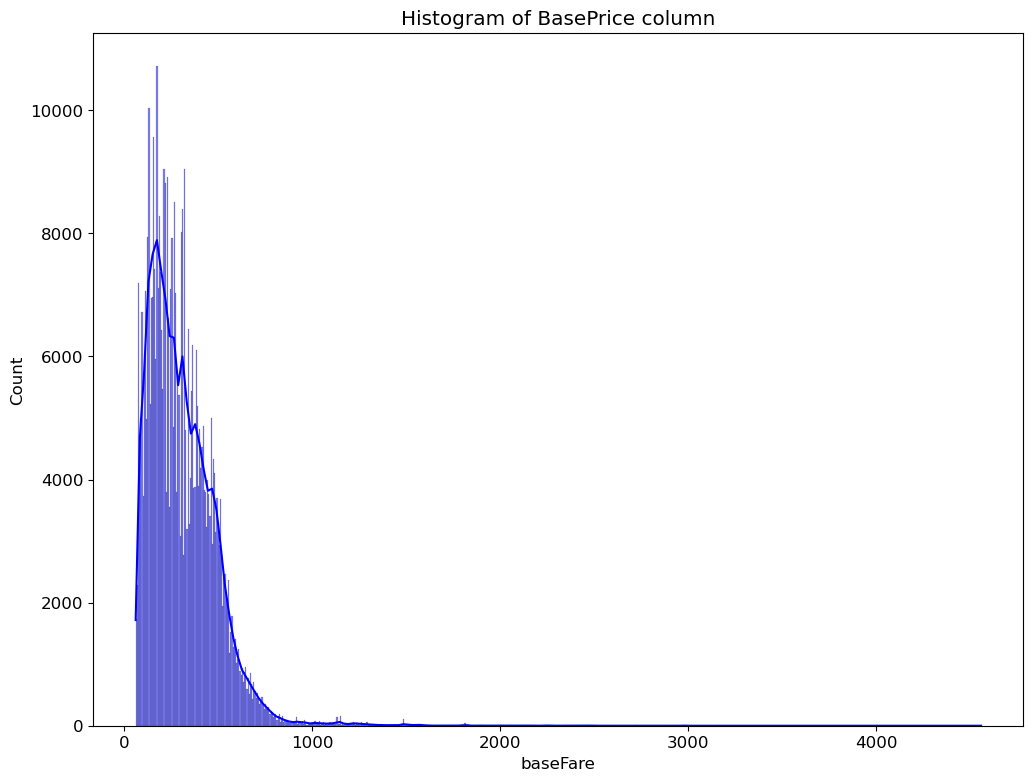

In [17]:
sns.histplot(data['baseFare'],color="blue",kde=True,label='baseFare')
plt.title("Histogram of BasePrice column")

Text(0.5, 1.0, 'Histogram of Log Base Price')

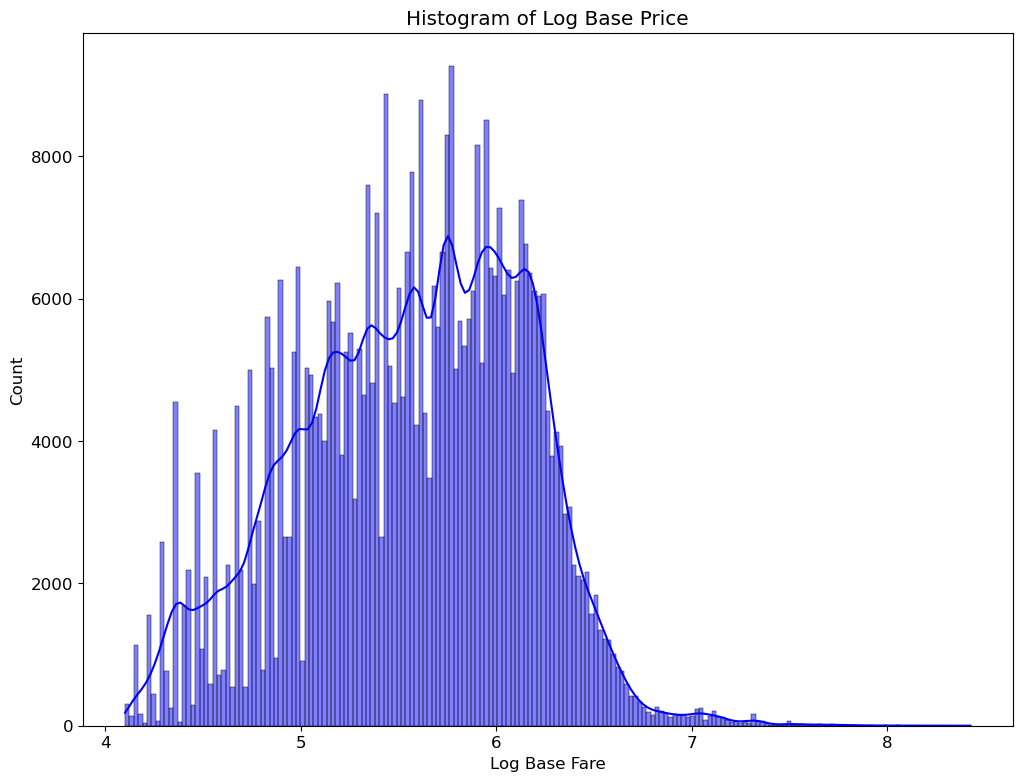

In [18]:
sns.histplot(np.log(data['baseFare']),color="blue",kde=True)
plt.xlabel("Log Base Fare")
plt.title("Histogram of Log Base Price")

From the plot it seems like most of the entries base price are in the range of **0-1500**. 

### Best Connected Airport (Airport with the highest traffic)

The best connected data will be the one which has the highest amount of traffic passing through it. The best connected airport will be found out using the arrival and departure data given in the dataframe.

The layovers will have redundant data i.e., the airport will be repeated in the arrival and departure columns which will be taken into account.

In [19]:
airportCodesSeries=data['segmentsArrivalAirportCode1'].append(data['segmentsArrivalAirportCode2']).append(data['segmentsArrivalAirportCode3']).append(data['segmentsDepartureAirportCode1'])
airportCodesSeries.value_counts().head(5)

ORD    96521
ATL    87834
CLT    87740
LAX    87118
BOS    81263
dtype: int64

Text(0, 0.5, 'Count')

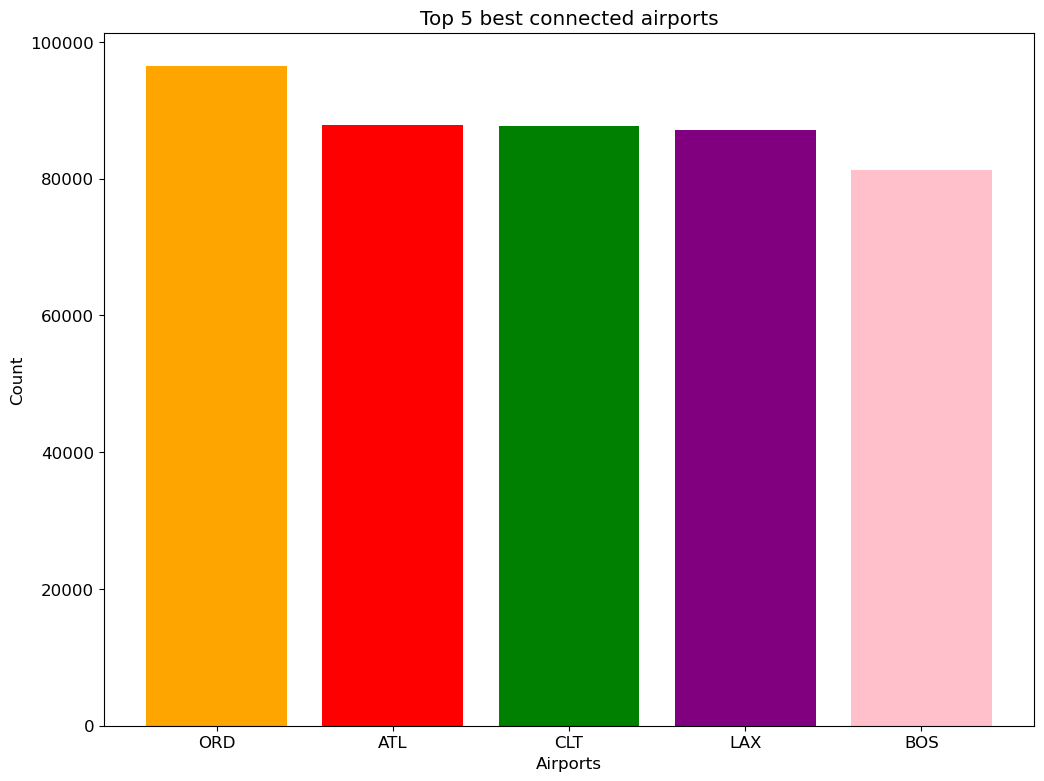

In [20]:
Height_plot=np.array(airportCodesSeries.value_counts().head(5))
plt.bar(x=airportCodesSeries.value_counts().head(5).index,height=Height_plot,color=['orange', 'red', 'green', 'purple', 'pink'])
plt.title("Top 5 best connected airports")
plt.xlabel("Airports")
plt.ylabel("Count")

The **Chicago, IL O’Hare (ORD)** airport is the best connected airport meaning that the highest amount of domestic air traffic goes through this airport compared to other airports in the United States.

### Fare price for different flight duration

Plotting a graph of Fare price vs flight duration will give an understanding of its trend and any correlation which might be present between the features.

Text(0.5, 1.0, 'Basefare vs Flight duration')

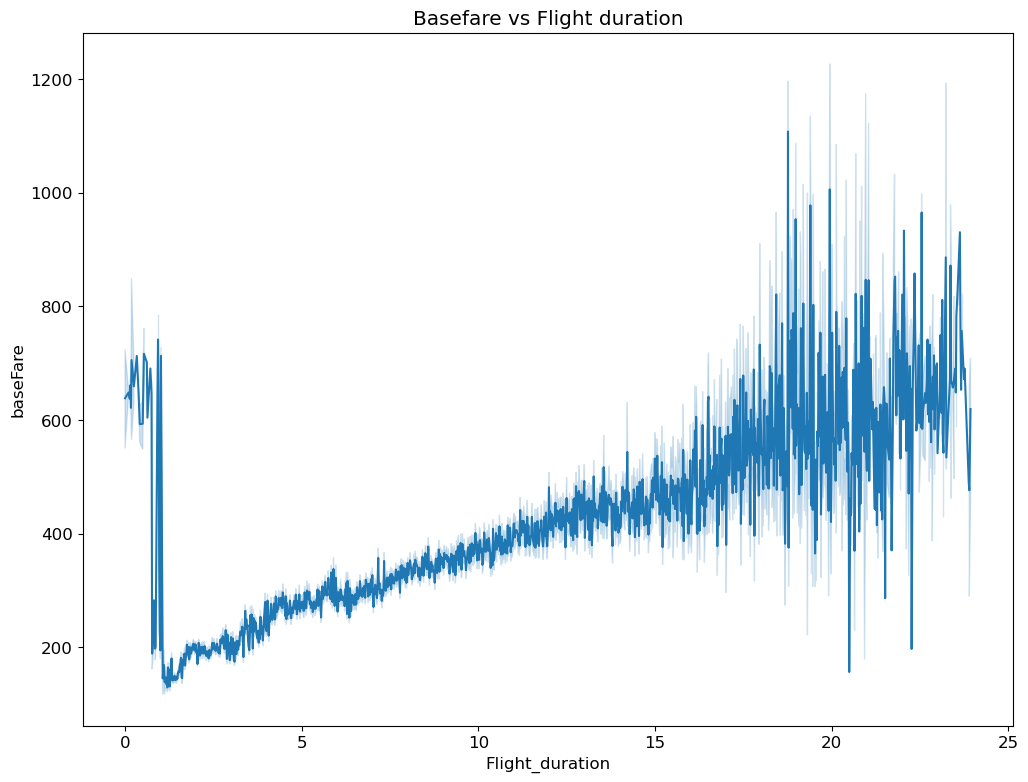

In [21]:
sns.lineplot(x=data["Flight_duration"], y=data["baseFare"])
plt.title("Basefare vs Flight duration")

(2.0, 15.0)

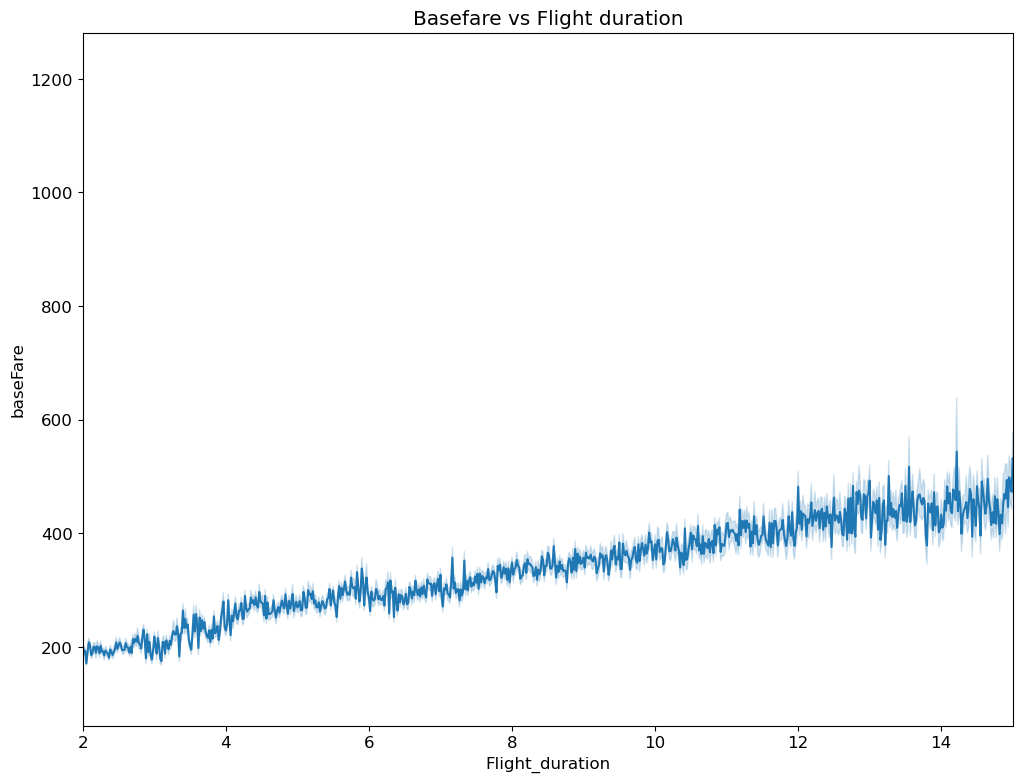

In [22]:
sns.lineplot(x=data["Flight_duration"], y=data["baseFare"])
plt.title("Basefare vs Flight duration")
plt.xlim([2, 15])

From the above plot there seems to be a **linear relationship** between flight duration and base fare in the range **2 to 15 hour** flights.

### The minimum and average distance for which people prefer flights

The distance travelled in each travel is calculated using segmentDistance columns and so the distance for which people prefer flights can be analyzed.

In [23]:
data.loc[:,['segmentsDistance','segmentsDistance1', 'segmentsDistance2', 'segmentsDistance3']]

,segmentsDistance,segmentsDistance1,segmentsDistance2,segmentsDistance3
0,280||185,280,185,NaN
1,505||241||434,505,241,434
2,338||2458,338,2458,NaN
3,185,185,NaN,NaN
4,762||185,762,185,NaN
...,...,...,...,...
499995,1985||505,1985,505,NaN
499996,228||725||1238,228,725,1238
499997,1602||1204||588,1602,1204,588
499998,720||1847,720,1847,NaN


In [24]:
data['segmentsDistance1']=data['segmentsDistance1'].fillna(0).astype(int)
data['segmentsDistance2']=data['segmentsDistance2'].fillna(0).astype(int)
data['segmentsDistance3']=data['segmentsDistance3'].fillna(0).astype(int)
data['totalDistance']=data['segmentsDistance1']+data['segmentsDistance2']+data['segmentsDistance3']

In [25]:
data['totalDistance'].describe(), data['totalDistance'].median()

(count    455587.000000
 mean       1625.940648
 std         855.455409
 min          89.000000
 25%         903.000000
 50%        1482.000000
 75%        2426.000000
 max        4498.000000
 Name: totalDistance, dtype: float64,
 1482.0)

The minimum distance travelled using domestic flights is **89 miles** and a median distance covered by domestic flights is **1482 miles**.

### Average number of seats remaining in each airlines

Seats remaining per flight gives a clear picture on which airlines has most seats unbooked, intern gives a clear picture on which airlines has more seats booked.

Average Seat Remaining column will provide the average seat remaining with respect to the total flight booking.

In [26]:
dataSegment1 = data.groupby('segmentsAirlineName1', as_index=False)['seatsRemaining'].sum()
dataSegment2 = data.groupby('segmentsAirlineName1', as_index=False)['seatsRemaining'].sum()
dataSegment2['averageSeatsRemaining'] = (dataSegment1['seatsRemaining']/len(data.index)).round(2)
dataSegment2 = dataSegment2.sort_values(by = 'seatsRemaining', ascending = True)
dataSegment1['averageSeatsRemaining'] = (dataSegment1['seatsRemaining']/len(data.index)).round(0)
dataSegment1 = dataSegment1.sort_values(by = 'seatsRemaining', ascending = False)
dataSegment1

,segmentsAirlineName1,seatsRemaining,averageSeatsRemaining
1,American Airlines,892833,2.0
5,Delta,874055,2.0
11,United,716045,2.0
7,JetBlue Airways,265087,1.0
0,Alaska Airlines,138644,0.0
6,Frontier Airlines,21910,0.0
8,Key Lime Air,1174,0.0
10,Sun Country Airlines,891,0.0
9,Southern Airways Express,788,0.0
2,Boutique Air,288,0.0


The barplot below depicts seat remaining status for the specific airlines.

**American airlines** has the most number of seats remaining. 

Text(0, 0.5, 'Airlines Name')

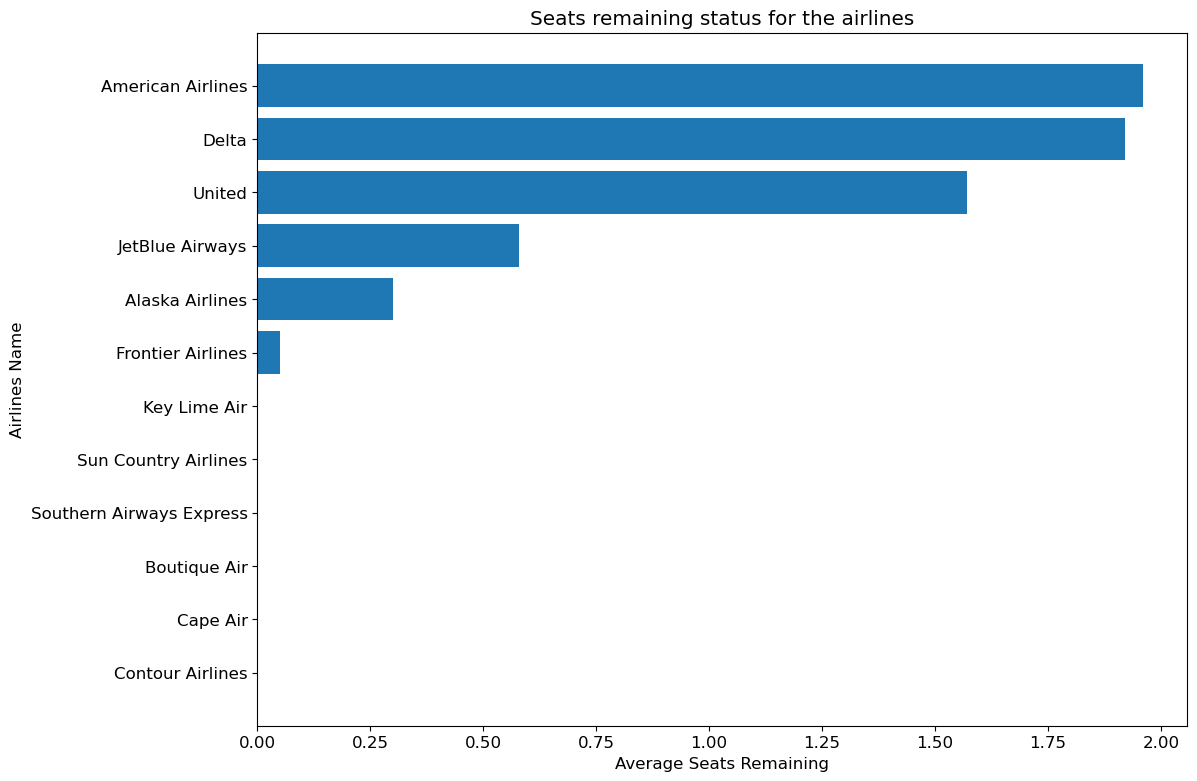

In [27]:
plt.barh(y=dataSegment2['segmentsAirlineName1'], width=dataSegment2['averageSeatsRemaining'])
plt.title('Seats remaining status for the airlines')
plt.xlabel('Average Seats Remaining')
plt.ylabel('Airlines Name')

### Top 5 popular airlines 

Popular airlines can be decided by the number of times the particular airlines is repeated in the booking. This gives the exact demographics of the airlines that is popular among the people taking flights.

In [28]:
airlineName=data['segmentsAirlineName1'].append(data['segmentsAirlineName2']).append(data['segmentsAirlineName3']).append(data['segmentsAirlineName1'])
airlineName = airlineName.value_counts().head(5)
airlineName

American Airlines    413094
Delta                346429
United               333000
JetBlue Airways       99124
Alaska Airlines       76781
dtype: int64

Text(0, 0.5, 'Airlines Count')

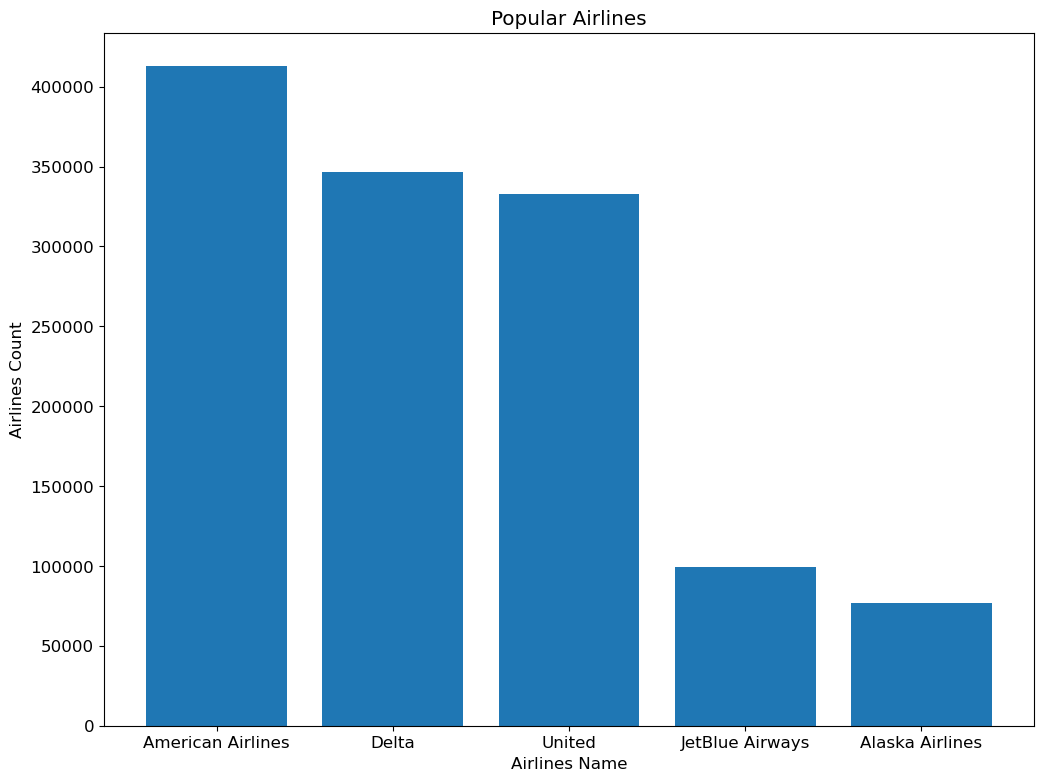

In [29]:
Height_plot=np.array(airlineName)
plt.bar(x=airlineName.index,height=Height_plot)
plt.title('Popular Airlines')
plt.xlabel('Airlines Name')
plt.ylabel('Airlines Count')

Above plot shows the popular 5 airlines with the total number of times that particular airlines is repeating.

**American airlines** is the most prefered airlines for the local travel among the individuals who take flights.

According to the previous analysis American Airlines is both the most popular and the one with most number of seats remaining. This intern says that seats remaining and number of times the airlines is repeating are correlated.

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Prediction of fare

### Feature engineering

### One hot encoding for categorical data

The categorical data present cannot be used directly in the prediction as they do not contain measurable data. The data is hence converted into features using `OneHotEncoder` from `sklearn`.

The columns identified to be OneHotEncoded are:
`startingAirport`, `destinationAirport`, `segmentsArrivalAirportCode`, `segmentsDepartureAirportCode`, `segmentsAirlineName`, `segmentsAirlineCode`, `segmentsCabinCode`.

In these columns, `segmentsAirlineName` and `segmentsAirlineCode` convey the same information and therefore redundant. One of the 2 columns is suffiecient and we have chosen `segmentsAirlineCode`.

The data of `startingAirport` and `destinationAirport` are already included in `segmentsArrivalAirportCode` and `segmentsDepartureAirportCode` and so are redundant information.

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
def oheCabinCodeColumns(oheData):
    """
        Inputs:
            oheData [Dataframe]: Dataframe on which the operation is performed
        
        Output:
            Dataframe with the OneHotEncoded features from the column 'segmentsCabinCode'
    """
    
    #columnName is the column to be OneHotEncoded
    columnName='segmentsCabinCode'
    
    #The column 'segmentsCabinCode' has been split into 3 different columns (the layover data) and so all the 3 columns have to be OneHotEncoded
    oneHotEnc = OneHotEncoder(dtype=int, handle_unknown='ignore')
    oheDataColumn3 = oneHotEnc.fit_transform(oheData[[columnName+'3']]).toarray()
    numberOfColumns3=np.shape(oheDataColumn3)[1]
    oheDataColumn2 = oneHotEnc.fit_transform(oheData[[columnName+'2']]).toarray()
    numberOfColumns2=np.shape(oheDataColumn2)[1]
    oheDataColumn1 = oneHotEnc.fit_transform(oheData[[columnName+'1']]).toarray()
    numberOfColumns1=np.shape(oheDataColumn1)[1]
    
    #The minimum number of columns are selected because the segment2 and segment3 have NaNs which are absent in segment1 and also unnecessary to the prediction
    numberOfColumns=min(numberOfColumns3, numberOfColumns2, numberOfColumns1)
    
    #The OR operation is done as the features from the 3 columns are the data of the same categories and so a common set of columns for all the 3 segments will suffice
    oheData[oneHotEnc.categories_[0]] = oheDataColumn1[:,:numberOfColumns] | oheDataColumn2[:,:numberOfColumns] | oheDataColumn3[:,:numberOfColumns]
    return oheData

In [32]:
def oheSegmentsAirportCode_AirlineName(oheData, columnName):
    """
        Inputs:
            oheData [Dataframe]: Dataframe on which the operation is performed
            columnName [String]: The column name (only the ones mentioned below) of the column to be OneHotEncoded
                                 Acceptable columnNames are 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', or 'segmentsAirlineCode'
        
        Output:
            Dataframe with the OneHotEncoded features from the column columnName
    """

    oneHotEnc = OneHotEncoder(dtype=int, handle_unknown='ignore')
    
    #The acceptable columnName columns have been split into 3 different columns (the layover data) and so all the 3 columns have to be OneHotEncoded
    #dfIntermediate dataframes are to get the features of each of the segments individually
    dfIntermediate3=pd.DataFrame()
    dfIntermediate2=pd.DataFrame()
    dfIntermediate1=pd.DataFrame()
    oheDataColumn3 = oneHotEnc.fit_transform(oheData[[columnName+'3']]).toarray()
    dfIntermediate3[oneHotEnc.categories_[0]]=oheDataColumn3
    oheDataColumn2 = oneHotEnc.fit_transform(oheData[[columnName+'2']]).toarray()
    dfIntermediate2[oneHotEnc.categories_[0]]=oheDataColumn2
    oheDataColumn1 = oneHotEnc.fit_transform(oheData[[columnName+'1']]).toarray()
    dfIntermediate1[oneHotEnc.categories_[0]]=oheDataColumn1
    
    #The OR operation is done as the features from the 3 columns are the data of the same categories and so a common set of columns for all the 3 segments will suffice
    dfIntermediate = (dfIntermediate3 | dfIntermediate2 | dfIntermediate1)
    
    #Dropping the feature NaN
    dfIntermediate = dfIntermediate.loc[:, dfIntermediate.columns.notna()]
    
    #Adding columnName as the prefix to the features to differentiate between the arrival and departure data
    dfIntermediate.columns=[columnName+'_'+iterator for iterator in dfIntermediate.columns]
    
    oheData[dfIntermediate.columns] = dfIntermediate
    
    #Replacing NaNs with 0
    oheData[dfIntermediate.columns] = oheData[dfIntermediate.columns].fillna(0).astype(int)
    return oheData

The categorical data have been coverted into features to be used in the prediction.

### Pipeline function

In [33]:
def process_data_gm(data, pipeline_functions):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data

def drop_columns(data, *col):
    """Drop columns passed as arguments."""
    return data.drop(list(col),axis=1)
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]
#(select_columns, ['Log baseFare','totalTravelDistance','isBasicEconomy', 'isRefundable', 'isNonStop','Flight_duration' ], None)

In [34]:
data_test=data.copy()

In [35]:
#processing the data on Feature engineering functions
def log_transform(data, col):
    data['Log ' + col] = np.log(data[col])
    return data

pipelines = [
    (log_transform, None, {'col': 'baseFare'}),
    #(select_columns, ['Log baseFare','totalTravelDistance','isBasicEconomy', 'isRefundable', 'isNonStop','Flight_duration' ], None),
    (oheCabinCodeColumns, None, None),
    (oheSegmentsAirportCode_AirlineName, None, {'columnName':'segmentsArrivalAirportCode'}),    
    (oheSegmentsAirportCode_AirlineName, None, {'columnName':'segmentsDepartureAirportCode'}),    
    (oheSegmentsAirportCode_AirlineName, None, {'columnName':'segmentsAirlineCode'}),    
    (drop_columns, ['legId', 'searchDate', 'flightDate','startingAirport','baseFare',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 
       'totalFare', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode','segmentsDepartureTimeRaw1','segmentsDepartureTimeRaw2','segmentsDepartureTimeRaw3',
        'segmentsArrivalTimeRaw1','segmentsArrivalTimeRaw2',
       'segmentsArrivalTimeRaw3', 'segmentsArrivalAirportCode1',
       'segmentsArrivalAirportCode2', 'segmentsArrivalAirportCode3',
       'segmentsDepartureAirportCode1', 'segmentsDepartureAirportCode2',
       'segmentsDepartureAirportCode3', 'segmentsAirlineName1',
       'segmentsAirlineName2', 'segmentsAirlineName3', 'segmentsAirlineCode1',
       'segmentsAirlineCode2', 'segmentsAirlineCode3',
       'segmentsEquipmentDescription1', 'segmentsEquipmentDescription2',
       'segmentsEquipmentDescription3','segmentsCabinCode1', 'segmentsCabinCode2', 'segmentsCabinCode3'], None)
]

In [36]:
data_test = process_data_gm(data_test, pipelines)

In [37]:
data_test.loc[:,['segmentsDepartureTimeEpochSeconds1',
       'segmentsDepartureTimeEpochSeconds2',
       'segmentsDepartureTimeEpochSeconds3',
       'segmentsArrivalTimeEpochSeconds1', 'segmentsArrivalTimeEpochSeconds2',
       'segmentsArrivalTimeEpochSeconds3', 'segmentsDurationInSeconds1',
       'segmentsDurationInSeconds2', 'segmentsDurationInSeconds3']]=data_test.loc[:,['segmentsDepartureTimeEpochSeconds1',
       'segmentsDepartureTimeEpochSeconds2',
       'segmentsDepartureTimeEpochSeconds3',
       'segmentsArrivalTimeEpochSeconds1', 'segmentsArrivalTimeEpochSeconds2',
       'segmentsArrivalTimeEpochSeconds3', 'segmentsDurationInSeconds1',
       'segmentsDurationInSeconds2', 'segmentsDurationInSeconds3']].fillna(0).astype(int)
data_test.dtypes.value_counts()

int32      393
int64        9
float64      3
dtype: int64

### Splitting data for testing, training and validation

We are splitting the data into three segments for testing, training and validation in the proportion of 8:1:1.

In [38]:
from sklearn.model_selection import train_test_split

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

X = data_test.drop(columns = ['Log baseFare']).copy()
y = data_test['Log baseFare']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(364469, 404)
(364469,)
(45559, 404)
(45559,)
(45559, 404)
(45559,)


(None, None)

### Prediction using Linear Regression without L2 Regularziation

In [39]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True) # creating the linear model

In [40]:
y_fitted = linear_model.fit(X_train, y_train) #fitting the model on x_train, y_train
y_predicted_test = linear_model.predict(X_test) # prediction using x_train
y_predicted_train = linear_model.predict(X_train) # prediction using X_train

#linear_model.coef_
linear_model.score(X_train, y_train), linear_model.score(X_test, y_test)

(0.5081170726230193, 0.50018262616869)

### Prediction with L2 Regularziation

In this model we will be adding Regulariziation to combat overfitting if present

In [41]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha = 100) # creating the Regularized model

In [42]:
y_fitted_l2= ridge_model.fit(X_train, y_train) #fitting the model on x_train, y_train
y_predicted_l2_test = ridge_model.predict(X_test)# prediction using x_train
ridge_model.score(X_test, y_test)
#ridge_model.coef_

0.4992857686284101

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Validation of model

### RMSE Value

Let's compare the performance of Linear regression models using the Root Mean Squared Error function:

$$RMSE = \sqrt{\dfrac{\sum_{\text{basefare in test set}}(\text{actual basefare} - \text{predicted basefare})^2}{\text{Total number of routes}}}$$

The function is provided below.

In [43]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [44]:
# Training and test errors for the Train and test set
training_error = rmse(y_predicted_train, y_train)
test_error = rmse(y_predicted_test, y_test)
val_error = rmse(linear_model.predict(X_valid), y_valid)

# Training and test errors (in its original values before the log transform)
training_error_delog = rmse(np.exp(y_predicted_train), np.exp(y_train))
test_error_delog = rmse(np.exp(y_predicted_test), np.exp(y_test))
val_error_delog = rmse(np.exp(linear_model.predict(X_valid)), np.exp(y_valid))

print("With Log transform\nTraining RMSE: {}\nTest RMSE: {}\nValidation RMSE: {}\n".format(training_error, test_error, val_error))
print("Without Log transform\nTraining RMSE: ${}\nTest RMSE: ${}\nValidation RMSE: ${}\n".format(training_error_delog.round(2), test_error_delog.round(2),val_error_delog.round(2)))

With Log transform
Training RMSE: 0.40584953237469107
Test RMSE: 0.4074738217477693
Validation RMSE: 0.40572369480273524

Without Log transform
Training RMSE: $133.49
Test RMSE: $132.42
Validation RMSE: $132.16



Training RMSE gives 0.406 value for dataset with log transform.\
Test RMSE gives 0.404 value for data set with log transform.\
Validation RMSE gives 0.405 value for data set with log transform.

Training RMSE gives $\$133.29$ for data set with no log transform.\
Test RMSE gives $\$133.01$ for data set with no log transform.\
Validation RMSE gives $\$133.06$ for data set with no log transform.

### Bias Variance Trade off

In [45]:
#from mlxtend.evaluate import bias_variance_decomp

#mse, bias, var = bias_variance_decomp(linear_model, np.array(X_train),np.array( y_train),np.array( X_test), np.array(y_test), loss='mse', num_rounds=200, random_seed=123)
#print('MSE from bias_variance lib [avg expected loss]: %.3f' % mse)
#print('Avg Bias: %.3f' % bias)
#print('Avg Variance: %.3f' % var)

### Plot of the model predictions versus the observations

Text(0, 0.5, 'Input Test base Price')

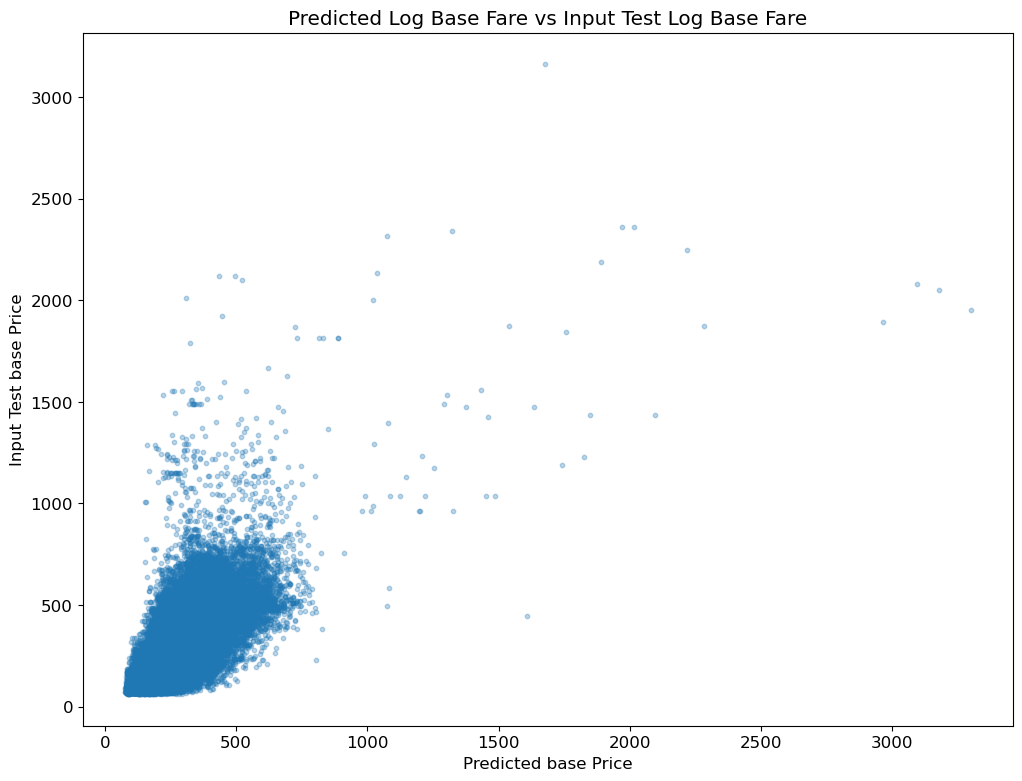

In [46]:
plt.scatter(x=np.exp(y_predicted_test),y=np.exp(y_test),s=10,alpha=0.3)
plt.title("Predicted Log Base Fare vs Input Test Log Base Fare")
plt.xlabel("Predicted base Price")
plt.ylabel("Input Test base Price")

Text(0, 0.5, 'Input Test base Price')

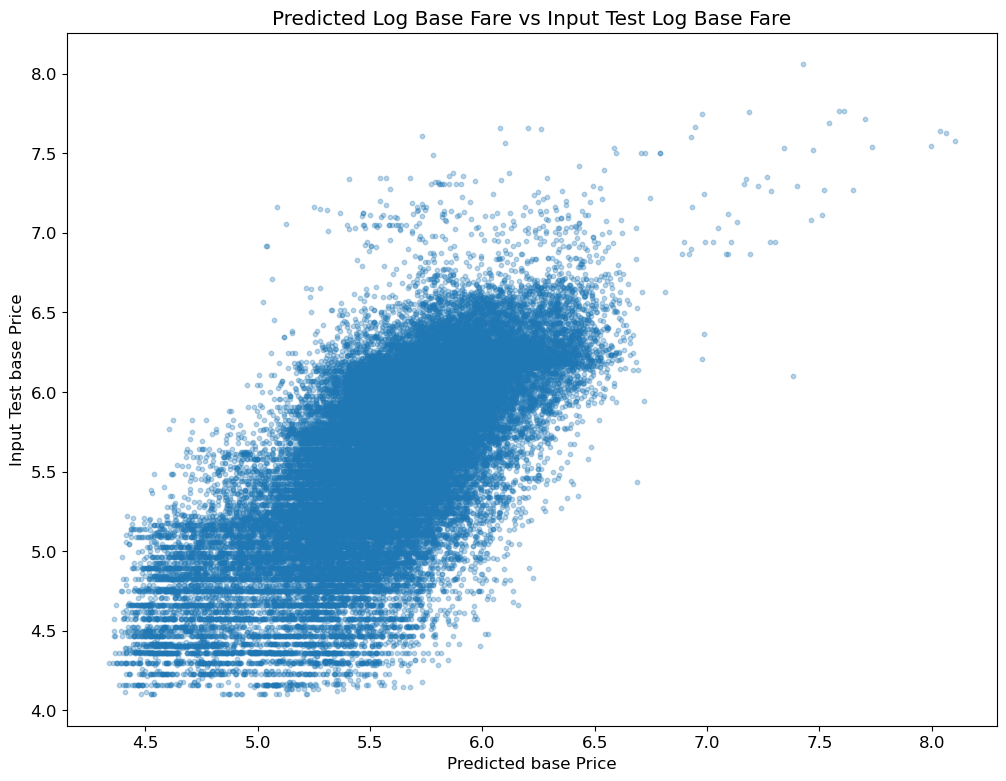

In [47]:
plt.scatter(x=y_predicted_test,y=y_test,s=10,alpha=0.3)
plt.title("Predicted Log Base Fare vs Input Test Log Base Fare")
plt.xlabel("Predicted base Price")
plt.ylabel("Input Test base Price")

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Inference and Conclusion

#### Through EDA we have the following inferences for the questions posed previously
1. Majority of the base fare were in the range **0-1500**.
2. The **Chicago, IL O’Hare (ORD)** airport is the best connected airport meaning that the highest amount of domestic air traffic goes through this airport compared to other airports in the United States.
3. A **linear relationship** is present between flight duration and base fare in the range **2 to 15 hour** flights.
4. The minimum distance people travel using domestic flights is **89 miles** and a median distance covered by domestic flights is **1482 miles**.
4. The average number of seats remaining for each airlines was found out.
5. The popular airlines for domestic travel in the US were found to be **American Airlines, Delta, United, JetBlue Airways, and Alaska Airlines** in that order.

For exploratory data analysis, we aim to find the airport with the highest traffic or the best-connected airports, the price of flights during the different hours of the day, the average/minimum travel distance for which people prefer flight, whether an average flight is fully booked/percentage of flights booked, and popular airlines.

#### Prediction Inference

The $R^{2}$ metric for linear regression is found to be 50.8% on train data and 50.02% on the test data.\
The RMSE is found to be $\$133.17$ for the training data and $\$135.05$ for the test data.\
MSE from bias_variance lib:\
[avg expected loss]: 0.166\
Avg Bias: 0.166\
Avg Variance: 0.000